In [1]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [2]:
target_sample_rate = 44100
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            wav_files.append(y)
    return wav_files

In [3]:
def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

In [4]:
# 指定 STFT 參數
hop_length = 512
n_mels = 256
n_fft = 2048

# 讀取分割後的音訊片段
segmented_files_normal = load_segmented_files('segmented_audio')
mel_spectrograms_normal = []


100%|██████████| 5170/5170 [00:21<00:00, 241.98it/s]


In [5]:
# 正規化音訊片段
segmented_files_normal = [normalize_audio(audio) for audio in tqdm(segmented_files_normal)]


100%|██████████| 5170/5170 [00:01<00:00, 3251.78it/s]


In [6]:
def convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=target_sample_rate, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

for audio in tqdm(segmented_files_normal):
    mel_spectrogram = convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels)
    mel_spectrograms_normal.append(mel_spectrogram)
    


100%|██████████| 5170/5170 [01:32<00:00, 55.68it/s]


In [7]:
def plot_mel_spectrogram(mel_spectrogram, filename:str = None):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{filename} Mel spectrogram')
    plt.savefig(f'{filename}_mel_spectrogram.png')
    plt.show()

# Spilt Dataset to training and testing

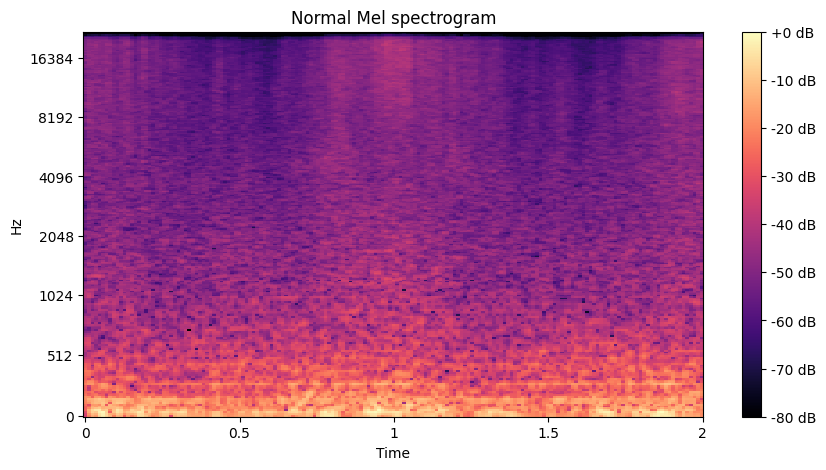

In [8]:
plot_mel_spectrogram(mel_spectrograms_normal[0], 'Normal')

In [9]:
from sklearn.model_selection import train_test_split

# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_array = np.array(mel_spectrograms_normal)

# 對數據進行切分
train_data, test_data = train_test_split(mel_spectrograms_array, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (3308, 256, 173)
驗證集數據形狀: (828, 256, 173)
測試集數據形狀: (1034, 256, 173)


# 調整數據的形狀

In [10]:
# 調整數據的形狀
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], val_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

# 數據歸一化到 [0, 1]
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
# 打印轉換後的數據形狀
print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (3308, 256, 173, 1)
驗證集數據形狀: (828, 256, 173, 1)
測試集數據形狀: (1034, 256, 173, 1)


# 創建 CNN Autoencoder 模型

In [11]:
from keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def create_cnn_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    input_height = input_shape[1]
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = Lambda(lambda x: x[:, :, :input_height, :])(decoded)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder



# 初始化模型

In [12]:
# 指定輸入形狀
input_shape = np.shape(train_data)[1:]

# 創建 CNN Autoencoder 模型
autoencoder = create_cnn_autoencoder(input_shape)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 173, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 173, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 87, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 87, 8)        1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 44, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 44, 8)         584   

In [15]:
def plot_model(autoencoder):
    from tensorflow.keras.utils import plot_model
    plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
    
plot_model(autoencoder)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
from tensorflow.keras.optimizers import Adam 
# 設定初始學習率
initial_learning_rate = 0.01

# 創建 Adam 優化器並指定學習率
optimizer = Adam(learning_rate=initial_learning_rate)


# 編譯模型
autoencoder.compile(optimizer='adam', loss='mse')

# 訓練模型

In [17]:
history = autoencoder.fit(train_data, train_data,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(test_data, test_data))

Epoch 1/100
207/207 [==============================] - 13s 24ms/step - loss: 0.0134 - val_loss: 0.0027
Epoch 2/100
207/207 [==============================] - 4s 22ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/100
207/207 [==============================] - 4s 22ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/100
207/207 [==============================] - 4s 22ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/100
207/207 [==============================] - 4s 22ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/100
207/207 [==============================] - 4s 22ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 7/100
207/207 [==============================] - 4s 22ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/100
207/207 [==============================] - 4s 22ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/100
207/207 [==============================] - 4s 22ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
207/207 [==============================] - 5s 22ms/step - loss: 0.00

# 評估模型

In [18]:
test_loss = autoencoder.evaluate(val_data, val_data)
print("Test loss:", test_loss)

26/26 [==============================] - 1s 15ms/step - loss: 0.0018
Test loss: 0.0017653320683166385


# 繪製訓練過程

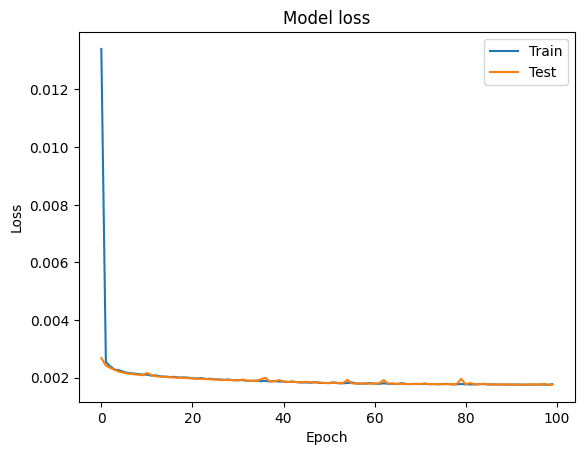

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()

# 儲存模型

In [21]:
autoencoder.save('mel_autoencoder.h5')

# 使用測試集數據進行預測

In [22]:
reconstructed_data = autoencoder.predict(test_data)

33/33 [==============================] - 1s 14ms/step


In [23]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title):
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    
    plt.tight_layout()
    plt.savefig('reconstructed_mel_spectrogram.png')
    plt.show()

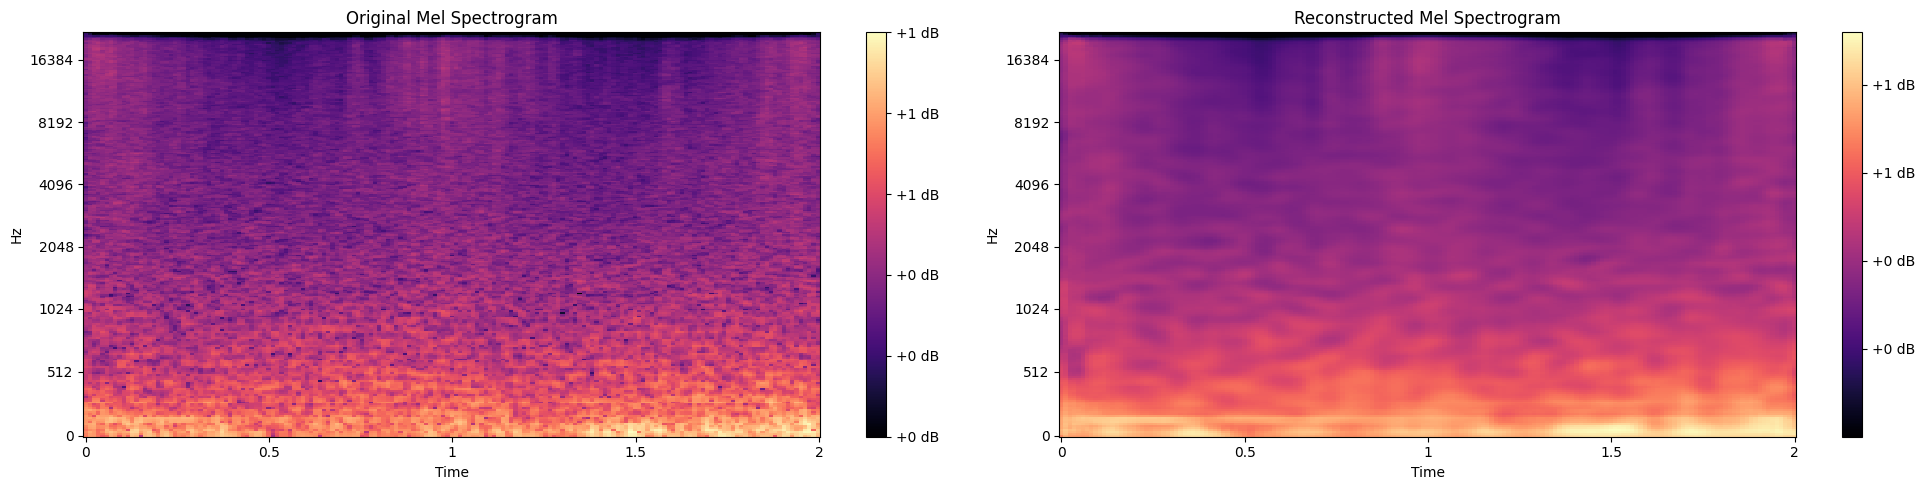

In [32]:
test_index = 300
plot_comparison(test_data[test_index].reshape(test_data[test_index].shape[0], test_data[test_index].shape[1]),
                reconstructed_data[test_index].reshape(reconstructed_data[test_index].shape[0], reconstructed_data[test_index].shape[1]),
                'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram')

計算評估指標

In [33]:
# 計算均方誤差 (MSE)
mse = np.mean((test_data - reconstructed_data) ** 2)
print("Reconstruction MSE:", mse)

# 計算平均絕對誤差 (MAE)
mae = np.mean(np.abs(test_data - reconstructed_data))
print("Reconstruction MAE:", mae)

# 計算均方根誤差 (RMSE)
rmse = np.sqrt(np.mean((test_data - reconstructed_data) ** 2))
print("Reconstruction RMSE:", rmse)

Reconstruction MSE: 0.0017557911
Reconstruction MAE: 0.029144995
Reconstruction RMSE: 0.041902162


In [34]:
segmented_files_anomaly = load_segmented_files('segmented_audio_anomaly')
segmented_files_anomaly = [normalize_audio(audio) for audio in tqdm(segmented_files_anomaly)]
mel_spectrograms_anomaly = []

for audio in tqdm(segmented_files_anomaly):
    mel_spectrogram = convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels)
    mel_spectrograms_anomaly.append(mel_spectrogram)

100%|██████████| 7590/7590 [00:52<00:00, 145.91it/s]


In [60]:
# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_anomaly_array = np.array(mel_spectrograms_anomaly)

In [61]:
# 調整數據的形狀
mel_spectrograms_anomaly_array = mel_spectrograms_anomaly_array.reshape(mel_spectrograms_anomaly_array.shape[0], mel_spectrograms_anomaly_array.shape[1], mel_spectrograms_anomaly_array.shape[2], 1)

# 數據歸一化到 [0, 1]
mel_spectrograms_anomaly_array = (mel_spectrograms_anomaly_array - mel_spectrograms_anomaly_array.min()) / (mel_spectrograms_anomaly_array.max() - mel_spectrograms_anomaly_array.min())

In [62]:
mel_spectrograms_anomaly_array_reconstructed = autoencoder.predict(mel_spectrograms_anomaly_array)

238/238 [==============================] - 2s 9ms/step


In [76]:
print(mel_spectrograms_anomaly_array.shape, mel_spectrograms_anomaly_array_reconstructed.shape)

(7590, 256, 173, 1) (7590, 256, 173, 1)


In [ ]:

for file in tqdm(os.listdir(directory)):
    if file.endswith(".wav"):
        file_path = os.path.join(directory, file)
        y, sr = librosa.load(file_path, sr=None)
        wav_files.append(y)

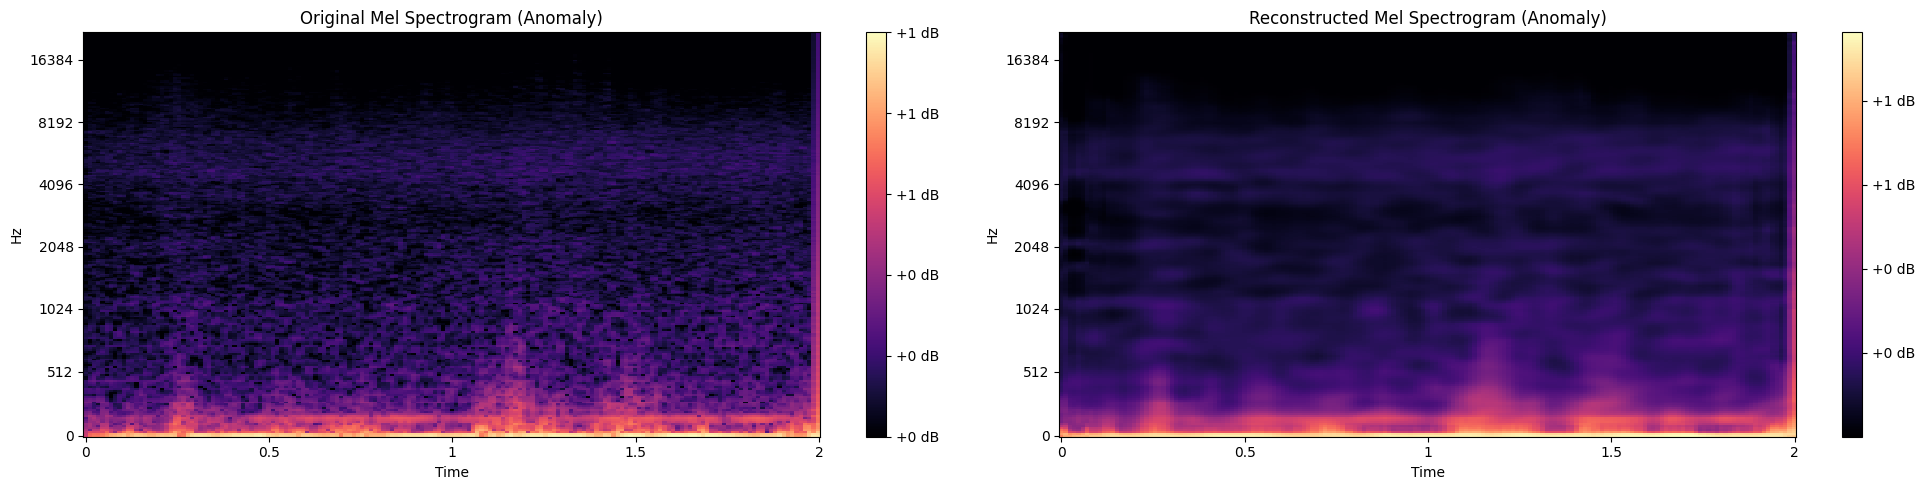

In [80]:
anomaly_index = 149
plot_comparison(
    mel_spectrograms_anomaly_array[anomaly_index].reshape(mel_spectrograms_anomaly_array[anomaly_index].shape[0], mel_spectrograms_anomaly_array[anomaly_index].shape[1]),
    mel_spectrograms_anomaly_array_reconstructed[anomaly_index].reshape(mel_spectrograms_anomaly_array_reconstructed[anomaly_index].shape[0], mel_spectrograms_anomaly_array_reconstructed[anomaly_index].shape[1]),
    'Original Mel Spectrogram (Anomaly)', 'Reconstructed Mel Spectrogram (Anomaly)')
import IPython.display as display
display.Audio(segmented_files_anomaly[anomaly_index], rate=target_sample_rate)

In [67]:
mse = np.mean((mel_spectrograms_anomaly_array - mel_spectrograms_anomaly_array_reconstructed) ** 2)
print("Reconstruction MSE (Anomaly):", mse)

Reconstruction MSE (Anomaly): 0.0017581576
